In [198]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
np.random.seed(70) #for reproducibility

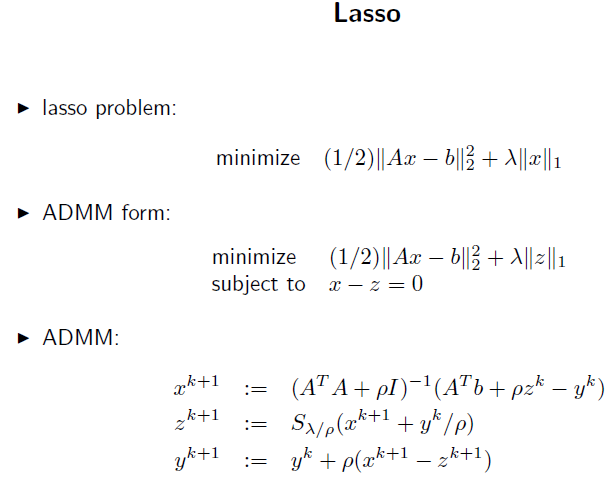

**Lasso Problem:**
$ \frac{1}{2} \| \mathbf{A}\mathbf{x} - \mathbf{b} \|_2^2 + \lambda \| \mathbf{x} \|_1$

**ADMM standard format:**   
Minimize:
$ f(x) + g(x)$

Subject to:
$ Ax + Bz = c$


**Lasso Problem in ADMM format:**\
Minimize:\
$ \mathbf{ \frac{1}{2} \| Ax - b \|_2^2 + \lambda \| z \|_1 } $

Subject to:\
$ \mathbf{ x - z = 0 } $

**Where:**\
$ \mathbf{A} \in \mathbb{R}^{Nb \times Nx} $ \
$ \mathbf{x} \in \mathbb{R}^{Nx} $ \
$ \mathbf{b} \in \mathbb{R}^{Nb} $ \
$ \mathbf{z} \in \mathbb{R}^{Nx} $

In [199]:
Nb = 1200 # Size of vector b
Nx = 3600 # Size of vector x

# np.random.randn generates random numbers from a standard normal distribution (mean = 0, std = 1)
A = np.random.randn(Nb, Nx)
true_coeffs = np.random.randn(Nx)
b = A @ true_coeffs + np.random.randn(Nb) * 0.2
x_init = np.zeros(Nx)
z_init = np.zeros(Nx)

# y represents the lagrange multiplier and dual variable
y_init = np.zeros(Nx)

epsilon = 1e-5
rho = 1.0
# Lambda is the regularization parameter for Lasso
# Do not confuse this with lagrange multiplier y
# Some people recommend starting with lambda = 1/Nx and then fine-tune from there
lambd = 0.01
print("Lambda: ", lambd)

Lambda:  0.01


In [200]:
print("Shape of roh*z_init: ", (rho*z_init).shape)
print("Shape of y_init: ", (y_init).shape)
print("Shape of A: ", (A).shape)
print("Shape of b: ", (b).shape)
print("Shape of A.T * b: ", (np.matmul(A.T, b)).shape)

Shape of roh*z_init:  (3600,)
Shape of y_init:  (3600,)
Shape of A:  (1200, 3600)
Shape of b:  (1200,)
Shape of A.T * b:  (3600,)


In [201]:
x = x_init
z = z_init
y = y_init
list_primal_res = []
list_dual_res = []
iters = np.arange(0, 1600) # max number of iterations

# (A.T * A + rho * I)^(-1)
cached_inv = np.linalg.inv(np.matmul(A.T, A) + rho*np.identity(Nx)) # O(n^3)
print("Shape of cached_inv: ", (cached_inv).shape)
print("Shape of A.T * b: ", (np.matmul(A.T, b)).shape)

Shape of cached_inv:  (3600, 3600)
Shape of A.T * b:  (3600,)


In [202]:
def soft_threshold(v, tau):
    """Apply the soft-thresholding operator to a scalar value."""
    return np.sign(v) * max(abs(v) - tau, 0)

def z_minimization_step(x, y, rho, lambda_):
    """Perform the z-minimization step in ADMM for Lasso."""
    tau = lambda_ / rho
    # Compute x^{k+1} + y^k / rho
    vector = x + y / rho
    # Apply soft-thresholding element-wise
    return np.array([soft_threshold(value, tau) for value in vector])


for k in iters:
    x = np.matmul(cached_inv, np.matmul(A.T, b) + rho*(z - y))
    z_prev = z  
    z = z_minimization_step(x, y, rho, lambd)
    y = y + rho * (x - z)       

    primal_res = np.linalg.norm(x - z, ord=2)
    dual_res = rho * np.linalg.norm(z - z_prev, ord=2)
    list_primal_res.append(primal_res)
    list_dual_res.append(dual_res)

    if primal_res < epsilon and dual_res < epsilon:
        break


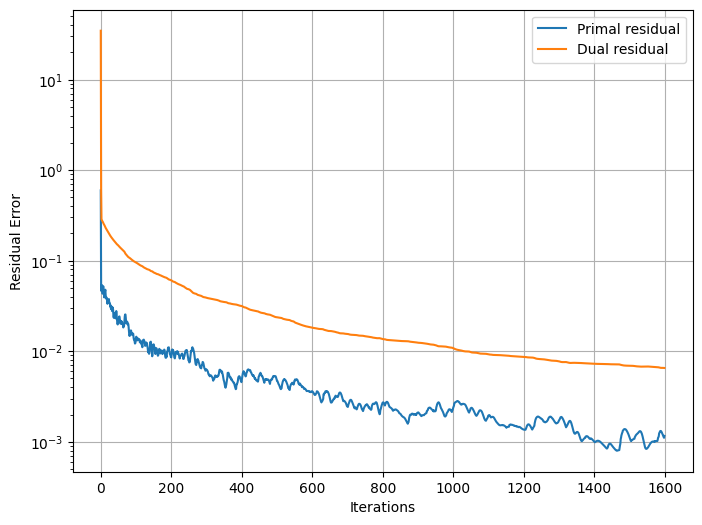

In [203]:
plt.figure(figsize=(8,6))
plt.plot(list_primal_res, label="Primal residual")
plt.plot(list_dual_res, label="Dual residual")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual Error")
plt.legend()
plt.grid()

In [204]:
# Create a DataFrame from the lists
df_residuals = pd.DataFrame({
    'PrimalResidual': list_primal_res,
    'DualResidual': list_dual_res
})

# Define the CSV file path
csv_file_path = 'residuals.csv'

# Export the DataFrame to a CSV file
df_residuals.to_csv(csv_file_path, index=False)